# <center>Project- The Battle of Neighborhoods</center>

## Introduction-Business Problem

In this Project We will try to explore and find best Indian Restaurents As we know that New-york is a multicultural city where lot of immigrants lives
so This project is targeted to those people how wants to eat their cultural food and for those companies who wants to recommend best restaurents to their 
users using this model.
<br>


We will use our data science powers to generate a few most promissing neighborhoods based on highest rating and tips.So Based on that we will suggest
users some Promising Neighborhoods/Restaurents according to their food preferences

## Data

Following data sources will be needed to extract/generate the required information:
    
    1. we will get New-york city data from  https://cocl.us/new_york_dataset which contains all borough and Neighborhood
        details along with their latitude and longitude.
        
    2. Restaurents details we will get from Foursquare Api which will contains information like Tips,Rating which will
       Certainly going to help us in this Project.
        
    3. Using https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm we will get all boroughs location 
       which will in creating boundaries for choropleth map.
    
    4. Using Visulizations libraries like Folium,Matplotlib we will show Visulizations of our Result.
    
    

## Method

1. We will first import all required libraries
2. we will Gather data from all the above sources for New-york city and Restaurants
3. After collecting info like Rating,tips,likes from Foursquare apis we will analyze and sort data(Restaurants)
4. We will Visualize data on map using Folium library

In [9]:
# Install Libraries

#!conda install -c conda-forge geopy --yes 
#!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         673 KB

The following NEW packages will be INSTALLED:

    altair:  4.0.1-py_0 conda-forge
    branca:  0.3.1-py_0 conda-forge
    folium:  0.5.0-py_0 conda-forge
    vincent: 0.4.4-py_1 conda-forge


branca-0.3.1         | 25 KB     | ##################################### | 1

In [14]:
#Importing Required Libraries

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import os
import folium # map rendering library
from geopy.geocoders import Nominatim# convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


we will define function which will help us getting lat,long of partcular addresses using geopy library

In [15]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [110]:
#Credentials For Foursquare api

CLIENT_ID='YOUR CLIENT ID'
CLIENT_SECRET='YOUR CLIENT SECRET ID'
VERSION = '20180604'
radius=1000
LIMIT=100

Using Foursquare api by using above credentials(Yours) define function which will return venue details under given radius

In [18]:

def get_venues(lat,lng):
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # send the requests to get data required
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df_venue = pd.DataFrame(venue_details,columns=column_names)
    return df_venue

We will define through which we will get details of Restuarants like tips,likes,Rating

In [59]:

def get_venue_details(venue_id):
        
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    #print(url)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

We will define function through which we will get into of NewYork city Neighborhoods

In [20]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [21]:
# Calling above function to get NewYork city data
new_york_data=get_new_york_data()

In [22]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [23]:
new_york_data.shape

(306, 4)

So We Found out that NewYork City has total Neighborhoods

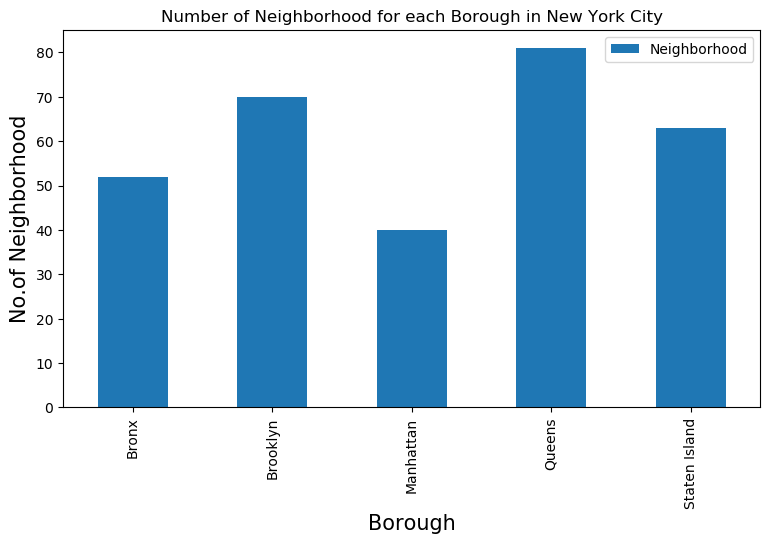

In [25]:

plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Neighborhood for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Neighborhood', fontsize=15)
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

By above visualization we can say that Queens has Highest Number of Neighborhoods and Manhattan has lowest.

Now We will define function through which we can get required info of indian restaurants in each Neighborhoods.

In [27]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

In [28]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [29]:
indian_rest_ny.shape

(146, 4)

So we got 146 Indian Restaurants now we will further analyze the data

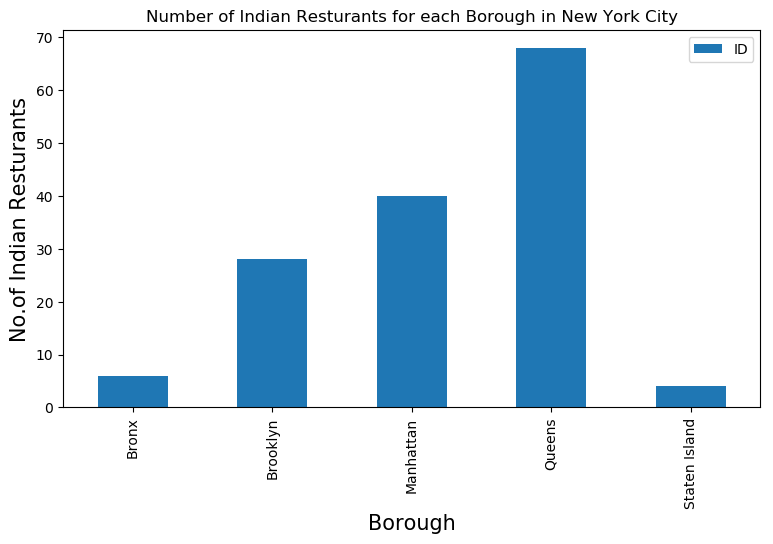

In [30]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Indian Resturants for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Indian Resturants', fontsize=15)
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

So By above Visulization we found out that Queens has highest number of indian Restaurent and Staten Island has lowest number of Indian 
Restaurants

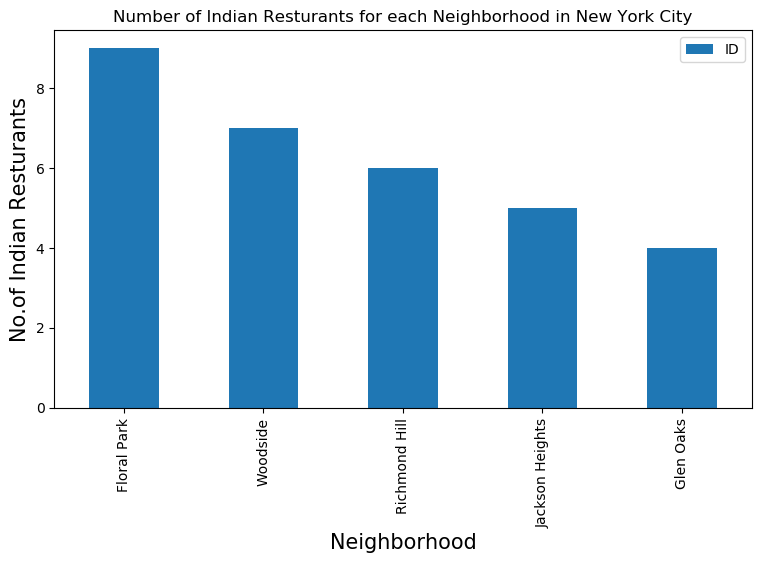

In [32]:
#Checking Now For Neighborhood
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No.of Indian Resturants', fontsize=15)

indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
plt.legend()
plt.show()

In Neighborhoods Floral Park having highest number of indian Restaturants

So will check For Floral Park in Queens

In [46]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
98,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
99,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
100,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
101,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
102,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
103,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
104,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
105,Queens,Floral Park,4cc642ed306e224b5bf2a76c,Shahi Darbar
106,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


So Now we will Analyze these Restaurants Further using Functions which we have defined at start

In [60]:

# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.6    10
( 1 / 146 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.2     2
( 2 / 146 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     6.0     9
( 3 / 146 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.6     3
( 4 / 146 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.2     2
( 5 / 146 ) processed
                         ID       Name  Likes  Rating  Tips
0  4b5a4dc8f964a520a2bb28e3  Taj Mahal     38     8.4    26
( 6 / 146 ) processed
                         ID          Name  Likes

KeyError: 'venue'

In [61]:
 indian_rest_stats_ny

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.6,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.2,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.0,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.6,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.2,2
5,Brooklyn,Bay Ridge,4b5a4dc8f964a520a2bb28e3,Taj Mahal,38,8.4,26
6,Brooklyn,Brighton Beach,4af0d31bf964a5207ddf21e3,Pak Nasheman,9,7.3,4
7,Brooklyn,Flatbush,52213c4211d295d4c57a607c,Ashoka Grill,8,7.0,14
8,Brooklyn,Flatbush,564d283d498e6e851df79d87,Great Indian Curry,3,6.9,2
9,Brooklyn,East Flatbush,512a9ea9e4b004fb8eeb84e5,Silver Krust,12,7.8,3


In [62]:
indian_rest_stats_ny.shape

(51, 7)

### Note-Due to Api quota exceed i am not able to fetch more than 51 rows so we will take 51 rows as our dataframe

In [65]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)


In [67]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [68]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.6,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.2,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.0,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.6,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.2,2


In [69]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 7 columns):
Borough         51 non-null object
Neighborhood    51 non-null object
ID              51 non-null object
Name            51 non-null object
Likes           51 non-null object
Rating          51 non-null float64
Tips            51 non-null object
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


In [70]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [71]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [72]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 7 columns):
Borough         51 non-null object
Neighborhood    51 non-null object
ID              51 non-null object
Name            51 non-null object
Likes           51 non-null float64
Rating          51 non-null float64
Tips            51 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [73]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                837
Rating                               8.8
Tips                                 260
Name: 39, dtype: object

In [74]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                                 9
Tips                                 146
Name: 42, dtype: object

In [75]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                837
Rating                               8.8
Tips                                 260
Name: 39, dtype: object

In [76]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [77]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
30,Tribeca,9.0
18,Midtown,8.8
34,West Village,8.8
11,Fort Greene,8.7
3,Chelsea,8.7
13,Gramercy,8.7
21,Murray Hill,8.6
36,Yorkville,8.6
22,North Side,8.4
27,Roosevelt Island,8.4


#### Above are the top restaurants with average rating overall

In [78]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [79]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.166667
1,Brooklyn,7.050000
0,Bronx,6.520000


#### Above are the average rating of Restaurants of each Borough

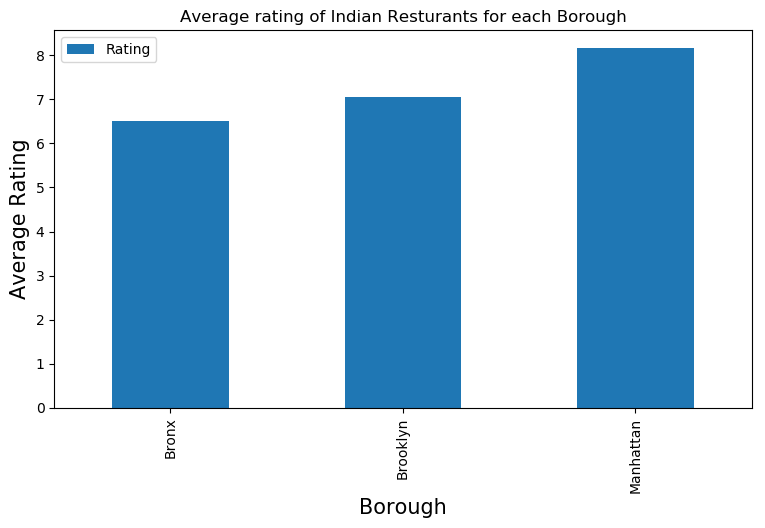

In [81]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Indian Resturants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
plt.legend()
plt.show()

In [88]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=6.0]

In [89]:
ny_neighborhood_stats

,Neighborhood,Average Rating
30,Tribeca,9.0


In [90]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [91]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [92]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Tribeca,40.721522,-74.010683,9.0


#### Now we will show this data on map using folium library

In [100]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [101]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [102]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough'] \
+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [103]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [107]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'
print("Hello")
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# we will save it to a file
ny_map.save('borough_rating.html')

Hello


## Result

AS we able to find best restaurents in Borough and Neighborhoods so we find out that Manhatten tribeca was the best restaurant in city.
But unfortunately because of api quota exceeded i am not able to take out full rows so that's why so have got less restaturants as result but 
as a Result we were able to explore and find out Indian Restaurants on varoius borough and neighborhoods of Newyork city

## Limitations

1. This model is accuracy based on data provided by Foursquare apis and other links(NewYork data)
2. Because of api quota only some of rows we were able to fetch out but solution to this problem is upgrade your package.

## Conclusion

This model is useful for explore out and find best Restaurants of various cuisines.By using Foursquare we are able to explore various indian restaurants
and filter out best restaurants for each Borough and Neighborhoods.This kind of model can help users to suggest restaurants and also some companies who
want to use this model to recommend their users to Best Restaurants near by their place. 